    This file is a part of the lor_neuro_rat project.
    Copyright (C) 2019 anonimous

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

    Please contact with me by E-mail: shkolnick.kun@gmail.com

In [9]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import h5py

import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

import gc
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
#from keras.layers import CuDNNLSTM, CuDNNGRU

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
#os.environ['OMP_NUM_THREADS'] = '4'

#from unidecode import unidecode

import time
%matplotlib inline

# Сформируем датасет

In [6]:
df = pd.read_pickle('data/XyWrdTokCat.pkl')

                         TopId             MsgId                      Creator  \
0        /forum/talks/12648516  comment-12649855      /people/mandala/profile   
1        /forum/talks/10056125  comment-10056157        /people/dvrts/profile   
2        /forum/talks/11903900  comment-11904141   /people/kiverattes/profile   
3        /forum/talks/12103367  comment-12103408   /people/alexferman/profile   
4  /forum/development/10968185  comment-10968212  /people/Progressive/profile   

                            Time                             SrcLink  \
0  2016-06-07T20:01:40.393+03:00  /forum/talks/12648516?cid=12649823   
1  2014-01-15T14:47:38.711+04:00                                       
2  2015-08-29T22:59:17.271+03:00  /forum/talks/11903900?cid=11904067   
3  2015-11-12T08:57:55.115+03:00  /forum/talks/12103367?cid=12103402   
4  2014-10-24T20:08:29.646+04:00                                       

                                           DelReason  \
0  Сообщение удалено по 

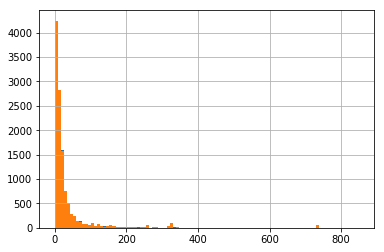

In [7]:
print(df.head())
print(df.describe())
df['TokCnt'].hist(bins=100)
df['WrdCnt'].hist(bins=100)

# Подготовка имбеддингов

In [64]:
print(df.groupby('Class').size())

df = df[df['Class'] != 16]

Class
1     2753
4     1397
5     3411
6     1094
7      372
8     2014
14     737
16       1
dtype: int64


In [81]:
from sklearn.utils.class_weight import compute_class_weight
#X
X = [' '.join(tokens) for tokens in list(df['Tokens'])]

#Считаем веса
y = df['Class'].values

l = LabelEncoder().fit(y)
y = l.transform(y)

cw = compute_class_weight('balanced', np.unique(y), y)
w = np.zeros(len(y))

print(cw)
for i in range(len(y)):
    w[i] = cw[y[i]]

#Получаем y
y = to_categorical(y)

[0.61117742 1.20441763 0.49327805 1.53799948 4.52304147 0.83543765
 2.28300058]


In [66]:
print(X[0])
print(X[1000])
print(X[10000])
print(y[0])
print(y[1000])
print(y[10000])

уровень развитие цивилизация лишь мы смотреть потомок крутить палец висок иметь значение этот ерунда вопрос страшно жить восклицание
мартышка зарабатывать корма тестирование мочь высказывать мнение
случаем устройство возможно посмотреть я самый вчера ещё винmobile пройти смс ки архив один шесть ть штука live получерновик смешно gmail точно помнить сколько два вроде непрочитанный пометить корова язык слизнуть сегодня рабочий ужас ждать нибыть синхронизация очень надеяться прилететь учётки привязать
[0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]


In [67]:
#Приделываем токенайзер из keras
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
print(len(tokenizer.word_index))

33605


In [68]:
wrds = []
idxs = []
for w, i in tokenizer.word_index.items():
    wrds.append(w)
    idxs.append(i)
    
if 'ебаный' in wrds:
    print(idxs[wrds.index('ебаный')])

1647


In [69]:
#Сохраняем токенайзер
with open('models/tokenizer_cat.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
#Грузим токенайзер
with open('models/tokenizer_cat.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [71]:
max_len = 150
X_seq = tokenizer.texts_to_sequences(X)
X_seq_pad = pad_sequences(X_seq, maxlen=max_len)

In [72]:
h5f = h5py.File('data/XyCat.h5', 'w')
print(h5f.create_dataset('X_seq_pad', data=X_seq_pad))
print(h5f.create_dataset('y', data=y))
h5f.close()

<HDF5 dataset "X_seq_pad": shape (11778, 150), type "<i4">
<HDF5 dataset "y": shape (11778, 7), type "<f4">


In [73]:
h5f = h5py.File('data/XyCat.h5', 'r')
X_seq_pad = h5f['X_seq_pad'][:]
y         = h5f['y'][:]
h5f.close()
print(X_seq_pad.shape)
print(y.shape)

(11778, 150)
(11778, 7)


In [74]:
#Вычисляем матрицу весов слоя имбеддингов
from pymagnitude import *
import gensim

mg = Magnitude('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.magnitude')
ft = gensim.models.fasttext.FastText.load('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model')

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words,300))

for word, i in word_index.items():
    #
    if i >= max_features: 
        continue
    #
    #embedding_matrix[i] = mg.query(word)
    try:
        embedding_matrix[i] = ft.wv[word]
    except:
        embedding_matrix[i] = mg.query(word)
    

In [75]:
#Сохраняем матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtxCat.h5', 'w')
print(h5f.create_dataset('EmbeddingMtx', data=embedding_matrix))
h5f.close()

<HDF5 dataset "EmbeddingMtx": shape (20000, 300), type "<f8">


In [76]:
#Грузим матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtxCat.h5', 'r')
embedding_matrix = h5f['EmbeddingMtx'][:]
h5f.close()

In [77]:
print(mg.most_similar(embedding_matrix[41]))

[('standard', 4.265022201977399), ('standart', 3.7154252871252442), ('poors', 3.0013121473366686), ('poor', 2.8666920197458454), ('classic', 2.859998851736054), ('investors', 2.83081380269601), ('platinum', 2.8074407921203863), ('premium', 2.7482584399840593), ('containers', 2.733958316173441), ('gold', 2.7106905770317318)]


In [78]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, cv_iter=0, arch=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val, self.Weigths = validation_data
        self.max_score = 0
        self.not_better_count = 0
        self._cv_iter = cv_iter
        self._arch = arch

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1, batch_size=512)
            score = roc_auc_score(self.y_val, y_pred, sample_weight=self.Weigths)
            
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save("models/best_model_%d_%d.h5"%(int(self._arch),int(self._cv_iter)))
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 5:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [95]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 0
def get_model(clipvalue=1.,num_filters=32,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(7, activation="softmax")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [40]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 4

from keras.layers import Add

def add_resnet_block(x, n, d, aFn = 'tanh'):
    x = SpatialDropout1D(d)(x)
    y = Bidirectional(LSTM(n, return_sequences=True, activation = aFn))(x)
    return Add()([x,y])

def get_model(clipvalue=1.,num_filters=32,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True, activation = 'relu'))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(7, activation="softmax")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [86]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 1
nn_arch = 1
def get_model(clipvalue=1.,num_filters=64,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    # Тут мы получаем конкатенацию LSTM по двум направлениям 
    # плюс Hidden state и Cell state по двум направлениям
    x, x_a, x_b, x_c, x_d = Bidirectional(LSTM(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_a, x_b, x_c, x_d, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(7, activation="softmax")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [74]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 2
nn_arch = 3
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    # Layer 6: output dense layer.
    outp = Dense(7, activation="softmax")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [46]:
#Model 3
nn_arch = 5
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = Dense(num_filters, activation="relu")(x)
    
    x = Flatten()(x)
    # Layer 6: output dense layer.
    outp = Dense(7, activation="softmax")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [98]:
from sklearn.metrics import classification_report

print('Model:' , nn_arch)
#model = get_model()

batch_size = 512

# Used epochs=100 with early exiting for best score.
epochs = 100
gc.collect()
K.clear_session()

# Change to 4
num_folds = 5 #number of folds

#Приводим типы
y = np.array(y)

#Веса примеров уже вычислили

kf = KFold(n_splits=num_folds, shuffle=True)

i = 0
for train_index, test_index in kf.split(X):
    
    gc.collect()
    K.clear_session()
    
    y_train = y[train_index] 
    y_test  = y[test_index]
    print(y_test.shape)
    
    X_train = X_seq_pad[train_index]
    X_test  = X_seq_pad[test_index]
    
    w_train = w[train_index]
    w_test  = w[test_index]
    
    model = get_model()
    #model.summary()
    
    ra_val = RocAucEvaluation(validation_data=(X_test, y_test, w_test), interval = 1, cv_iter=i, arch=nn_arch)
    
    model.fit(X_train, y_train, sample_weight=w_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    
    y_t = load_model("models/best_model_%d_%d.h5"%(int(nn_arch),int(i))).predict(X_test, verbose=1, batch_size=512)
    y_a = (y_t>0.5).astype('float').reshape(y_test.shape)
    
    print('Weighted scores')
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_t, axis=1), sample_weight=w_test))

    print('Scores')
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_t, axis=1)))
    
    gc.collect()
    
    i += 1

print("Done")

Model: 0
(2356, 7)
Epoch 1/100
2356/2356 [==============================] - 1s 241us/step
(2356, 7)

 ROC-AUC - epoch: 1 - score: 0.677302 

*** New High Score (previous: 0.000000) 

Epoch 2/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 2 - score: 0.716179 

*** New High Score (previous: 0.677302) 

Epoch 3/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 3 - score: 0.740809 

*** New High Score (previous: 0.716179) 

Epoch 4/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 4 - score: 0.754318 

*** New High Score (previous: 0.740809) 

Epoch 5/100
2356/2356 [==============================] - 0s 184us/step
(2356, 7)

 ROC-AUC - epoch: 5 - score: 0.763483 

*** New High Score (previous: 0.754318) 

Epoch 6/100
2356/2356 [==============================] - 0s 201us/step
(2356, 7)

 ROC-AUC - epoch: 6 - score: 0.771872 

*** New High Score (previous: 0.763483)

(2356, 7)

 ROC-AUC - epoch: 32 - score: 0.838408 

Epoch 33/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 33 - score: 0.838399 

Epoch 34/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 34 - score: 0.839458 

*** New High Score (previous: 0.838505) 

Epoch 35/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 35 - score: 0.839598 

*** New High Score (previous: 0.839458) 

Epoch 36/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 36 - score: 0.840015 

*** New High Score (previous: 0.839598) 

Epoch 37/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 37 - score: 0.840075 

*** New High Score (previous: 0.840015) 

Epoch 38/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 38 - score: 0.840770 

*** New High Score (previous: 0.8400

Epoch 4/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 4 - score: 0.762100 

*** New High Score (previous: 0.754064) 

Epoch 5/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 5 - score: 0.769761 

*** New High Score (previous: 0.762100) 

Epoch 6/100
2356/2356 [==============================] - 0s 178us/step
(2356, 7)

 ROC-AUC - epoch: 6 - score: 0.778093 

*** New High Score (previous: 0.769761) 

Epoch 7/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 7 - score: 0.785035 

*** New High Score (previous: 0.778093) 

Epoch 8/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 8 - score: 0.793644 

*** New High Score (previous: 0.785035) 

Epoch 9/100
2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 9 - score: 0.799314 

*** New High Score (previous: 0.793644) 

Epoch 10/100
235

2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 36 - score: 0.849889 

Epoch 37/100
2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 37 - score: 0.852154 

*** New High Score (previous: 0.850048) 

Epoch 38/100
2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 38 - score: 0.849732 

Epoch 39/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 39 - score: 0.851078 

Epoch 40/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 40 - score: 0.852117 

Epoch 41/100
2356/2356 [==============================] - 0s 183us/step
(2356, 7)

 ROC-AUC - epoch: 41 - score: 0.851111 

Epoch 42/100
2356/2356 [==============================] - 0s 180us/step
(2356, 7)

 ROC-AUC - epoch: 42 - score: 0.851567 

Epoch 43/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 43

2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 20 - score: 0.843569 

*** New High Score (previous: 0.842584) 

Epoch 21/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 21 - score: 0.844089 

*** New High Score (previous: 0.843569) 

Epoch 22/100
2356/2356 [==============================] - 0s 177us/step
(2356, 7)

 ROC-AUC - epoch: 22 - score: 0.845481 

*** New High Score (previous: 0.844089) 

Epoch 23/100
2356/2356 [==============================] - 0s 179us/step
(2356, 7)

 ROC-AUC - epoch: 23 - score: 0.846347 

*** New High Score (previous: 0.845481) 

Epoch 24/100
2356/2356 [==============================] - 0s 181us/step
(2356, 7)

 ROC-AUC - epoch: 24 - score: 0.847788 

*** New High Score (previous: 0.846347) 

Epoch 25/100
2356/2356 [==============================] - 0s 182us/step
(2356, 7)

 ROC-AUC - epoch: 25 - score: 0.847932 

*** New High Score (previous: 0.847788) 

Epoch 26/100
2356

(2355, 7)
Epoch 1/100
2355/2355 [==============================] - 1s 291us/step
(2355, 7)

 ROC-AUC - epoch: 1 - score: 0.724081 

*** New High Score (previous: 0.000000) 

Epoch 2/100
2355/2355 [==============================] - 0s 182us/step
(2355, 7)

 ROC-AUC - epoch: 2 - score: 0.752165 

*** New High Score (previous: 0.724081) 

Epoch 3/100
2355/2355 [==============================] - 0s 179us/step
(2355, 7)

 ROC-AUC - epoch: 3 - score: 0.770251 

*** New High Score (previous: 0.752165) 

Epoch 4/100
2355/2355 [==============================] - 0s 181us/step
(2355, 7)

 ROC-AUC - epoch: 4 - score: 0.785352 

*** New High Score (previous: 0.770251) 

Epoch 5/100
2355/2355 [==============================] - 0s 181us/step
(2355, 7)

 ROC-AUC - epoch: 5 - score: 0.796884 

*** New High Score (previous: 0.785352) 

Epoch 6/100
2355/2355 [==============================] - 0s 180us/step
(2355, 7)

 ROC-AUC - epoch: 6 - score: 0.805186 

*** New High Score (previous: 0.796884) 

Epoch 

2355/2355 [==============================] - 0s 197us/step
(2355, 7)

 ROC-AUC - epoch: 32 - score: 0.853615 

*** New High Score (previous: 0.853261) 

Epoch 33/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 33 - score: 0.853676 

*** New High Score (previous: 0.853615) 

Epoch 34/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 34 - score: 0.854712 

*** New High Score (previous: 0.853676) 

Epoch 35/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 35 - score: 0.855058 

*** New High Score (previous: 0.854712) 

Epoch 36/100
2355/2355 [==============================] - 0s 177us/step
(2355, 7)

 ROC-AUC - epoch: 36 - score: 0.855554 

*** New High Score (previous: 0.855058) 

Epoch 37/100
2355/2355 [==============================] - 0s 180us/step
(2355, 7)

 ROC-AUC - epoch: 37 - score: 0.855972 

*** New High Score (previous: 0.855554) 

Epoch 38/100
2355

2355/2355 [==============================] - 0s 179us/step
(2355, 7)

 ROC-AUC - epoch: 9 - score: 0.814413 

*** New High Score (previous: 0.807623) 

Epoch 10/100
2355/2355 [==============================] - 0s 179us/step
(2355, 7)

 ROC-AUC - epoch: 10 - score: 0.817857 

*** New High Score (previous: 0.814413) 

Epoch 11/100
2355/2355 [==============================] - 0s 179us/step
(2355, 7)

 ROC-AUC - epoch: 11 - score: 0.820755 

*** New High Score (previous: 0.817857) 

Epoch 12/100
2355/2355 [==============================] - 0s 207us/step
(2355, 7)

 ROC-AUC - epoch: 12 - score: 0.825221 

*** New High Score (previous: 0.820755) 

Epoch 13/100
2355/2355 [==============================] - 0s 200us/step
(2355, 7)

 ROC-AUC - epoch: 13 - score: 0.827750 

*** New High Score (previous: 0.825221) 

Epoch 14/100
2355/2355 [==============================] - 0s 199us/step
(2355, 7)

 ROC-AUC - epoch: 14 - score: 0.828759 

*** New High Score (previous: 0.827750) 

Epoch 15/100
2355/

2355/2355 [==============================] - 0s 180us/step
(2355, 7)

 ROC-AUC - epoch: 41 - score: 0.849041 

*** New High Score (previous: 0.848376) 

Epoch 42/100
2355/2355 [==============================] - 0s 177us/step
(2355, 7)

 ROC-AUC - epoch: 42 - score: 0.848572 

Epoch 43/100
2355/2355 [==============================] - 0s 177us/step
(2355, 7)

 ROC-AUC - epoch: 43 - score: 0.847980 

Epoch 44/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 44 - score: 0.850075 

*** New High Score (previous: 0.849041) 

Epoch 45/100
2355/2355 [==============================] - 0s 177us/step
(2355, 7)

 ROC-AUC - epoch: 45 - score: 0.849332 

Epoch 46/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 46 - score: 0.849281 

Epoch 47/100
2355/2355 [==============================] - 0s 178us/step
(2355, 7)

 ROC-AUC - epoch: 47 - score: 0.848481 

Epoch 48/100
2355/2355 [==============================] - 0s 

In [103]:
print(list(l.inverse_transform([0,1,2,3,4,5,6])))

[1, 4, 5, 6, 7, 8, 14]


In [111]:
class_lut       = pd.read_csv('data/markup/class_lut.csv', sep = ',')
print(class_lut.head())

desc_lut = dict(zip(list(class_lut['Class'].values), list(class_lut['Desc'].values)))

   Class                                  Desc  Use
0      0            Не поддается классификации    0
1      1             5.1 Нецензурные выражения    1
2      2                            3.1 Дубль     0
3      3  3.2, 3.3, 3.4 Форматирование и т. п.    0
4      4                          4.1 Offtopic    1


In [113]:
import pickle as pk
lreason = []
for i in list(l.inverse_transform(list(range(len(y[0]))))):
    lreason.append(desc_lut[i].split(' ')[0])

print(lreason)
    
with open('models/cat_list.pkl', 'wb+') as f:
    pk.dump(lreason, f)
    

['5.1', '4.1', '4.3', '5.3', '4.2', '5.2', '4.6']
